This notebook produces the analyses for figure 4 and accompanying supplemental materials

In [ ]:
#setup

import subprocess

import os, sys, csv

import subprocess
import glob
import gzip
import pandas as pd

#plotting packages
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px

import time

import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

from statsmodels.stats.multitest import multipletests

from Bio import Entrez, SeqIO
from Bio.Seq import Seq


#input directories
pwd = os.getcwd()
data_dir = os.path.join(pwd,"biobloomrxiv_source_data") #suggested data directory, data available at figshare 10.6084/m9.figshare.31053121


#output directories, configure as needed
fig4_out = os.path.join(pwd,"figures","fig4")

In [6]:
# load dataframe of all observed donors and their counts. These donors are already parsed for mutations
#note that csv is large, takes ~30 seconds to load
donor_muts_path = os.path.join(data_dir, "parsed_donors.csv")
donor_muts = pd.read_csv(donor_muts_path)
print(f"Total number of total unique mutation observations: {len(donor_muts)}")

### for most analyses, we are interested in the "clean" or "intended" mutations
#these are mutations that are at the intended, variable edit position
donor_muts_clean_df = donor_muts.copy()
donor_muts_clean_df = donor_muts_clean_df[donor_muts_clean_df['pos_donor'].between(38, 42)]
print(f"Total number of total unique clean mutation observations: {len(donor_muts_clean_df)}")



Total number of total unique mutation observations: 21747047
Total number of total unique clean mutation observations: 13991573


In [ ]:
### visualize
donor_muts_clean_df

,samplenum,read_name,pos,pos_donor,ref,alt,seq_read,readname,count
0,10,read357859_count28,153,40,C,A,ACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGAACAGA...,357859,28
1,10,read595557_count17,154,40,A,G,CTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCGCAGAC...,595557,17
2,10,read590658_count17,158,40,A,T,GGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGTCAGAT...,590658,17
5,10,read665307_count15,158,40,A,C,GGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGCCAGAT...,665307,15
6,10,read464289_count22,161,40,G,T,CACTAAATACTTTAACCAATATAGGCATAGCGCACAGACATATAAA...,464289,22
...,...,...,...,...,...,...,...,...,...
21747042,9,read65148_count11,4640691,40,A,C,TTTCGTCACATTATTTTAATAATCCAACTAGTTGCATCATCCAACT...,65148,11
21747043,9,read78758_count10,4640694,40,A,G,CGTCACATTATTTTAATAATCCAACTAGTTGCATCATACAGCTAAT...,78758,10
21747044,9,read80822_count10,4640697,40,A,C,CACATTATTTTAATAATCCAACTAGTTGCATCATACAACTCATAAA...,80822,10
21747045,9,read71448_count11,4640912,40,G,C,ATTCGCACCGCGTAATAAGTTGACAGTGATCACCCGGTTCCCGGTT...,71448,11


In [8]:
#then, combine evidence for mutations across donors
# keeping track of counts, pooled across all donors where the mutation occurs
all_mutations_df = (
    donor_muts_clean_df
    .groupby(["pos", "ref", "alt","samplenum"], as_index=False)["count"]
    .sum()
    .rename(columns={"count": "all_count"})
)
all_mutations_df

,pos,ref,alt,samplenum,all_count
0,46,A,G,5,14
1,48,A,T,5,17
2,49,A,G,4,19
3,115,T,C,1,11
4,115,T,G,1,12
...,...,...,...,...,...
10745368,4641568,C,G,4,11
10745369,4641569,G,C,6,15
10745370,4641570,A,C,1,19
10745371,4641571,G,T,4,10


In [4]:
#for some summary stats, need to have metadata like conditions, timepoint, etc
metadat_path = os.path.join(data_dir, "fullgenome_metadata_tidy.csv")
metadat = pd.read_csv(metadat_path)
metadat["samplenum"]= metadat["Sample_ID"]
metadat.drop("Sample_ID", axis=1, inplace=True)


all_mutations_df_annot = pd.merge(all_mutations_df, metadat, on= "samplenum")

#free up memory CAUTION this will disable working with these dataframes afterward
del donor_muts
del all_mutations_df
del donor_muts_clean_df
import gc
gc.collect()

all_mutations_df_annot

,pos,ref,alt,samplenum,all_count,tx_name,selection_type,rep,time_day,notes,preex_hit
0,46,A,G,5,14,56,none,B,0,Induced cultures,y
1,48,A,T,5,17,56,none,B,0,Induced cultures,y
2,49,A,G,4,19,56,none,A,0,Induced cultures,y
3,115,T,C,1,11,1234,none,A,0,Induced cultures,n
4,115,T,G,1,12,1234,none,A,0,Induced cultures,n
...,...,...,...,...,...,...,...,...,...,...,...
10745368,4641568,C,G,4,11,56,none,A,0,Induced cultures,y
10745369,4641569,G,C,6,15,56,none,C,0,Induced cultures,y
10745370,4641570,A,C,1,19,1234,none,A,0,Induced cultures,n
10745371,4641571,G,T,4,10,56,none,A,0,Induced cultures,y


In [5]:
#fetch genome information, for gene-level annotation
from fetch_genes import fetch_sequence, extract_gene_info

#Fetch genome and extract gene coordinates
load = True
if load: record = fetch_sequence("U00096.3")
if load: gene_df = extract_gene_info(record)



In [6]:
metadat

,tx_name,selection_type,rep,time_day,notes,preex_hit,samplenum
0,1234,none,A,0,Induced cultures,n,1
1,1234,none,B,0,Induced cultures,n,2
2,1234,none,C,0,Induced cultures,n,3
3,56,none,A,0,Induced cultures,y,4
4,56,none,B,0,Induced cultures,y,5
5,56,none,C,0,Induced cultures,y,6
6,1234,rif,A,1,"independently plated to rif, scraped",n,7
7,1234,rif,B,1,"independently plated to rif, scraped",n,8
8,1234,rif,C,1,"independently plated to rif, scraped",n,9
9,56,salt,A,1,preps were weird- don't wash salt-stressed cel...,y,10


In [7]:
### i'd also like to annotate genes and intergenic regions
#this function uses interval trees to make the lookup fast
#it depends on the gene_df dataframe, which is generated in the fetch_genes.py file

from intervaltree import IntervalTree
from bisect import bisect_right

# Pre-sort gene intervals for efficient lookup
sorted_genes = gene_df.sort_values("Start").reset_index(drop=True)
gene_starts = sorted_genes["Start"].values
gene_ends = sorted_genes["End"].values
gene_names = sorted_genes["Gene"].values


# Build interval tree once from gene_ranges
gene_tree = IntervalTree()
for _, row in gene_df.iterrows():
    gene_tree[row['Start']:row['End'] + 1] = row['Gene']  # inclusive end


def fast_annotate(pos):
    matches = gene_tree[pos]
    if matches:
        return list(matches)[0].data  # In a gene

    # Position is intergenic — find surrounding genes
    idx = bisect_right(gene_starts, pos)

    if idx == 0:
        # Before first gene
        return f"intergenic_before_{gene_names[0]}"
    elif idx >= len(gene_starts):
        # After last gene
        return f"intergenic_after_{gene_names[-1]}"
    else:
        # Between two genes
        upstream_gene = gene_names[idx - 1]
        downstream_gene = gene_names[idx]
        return f"intergenic_between_{upstream_gene}_and_{downstream_gene}"

In [8]:
#because the distribution of counts/z-scores appears pretty smooth, with no obvious "cutoff" that would make it easy to pick positives from null,
# we use a permutation test to determine the significance of each mutation, a proxy for enrichment/selection

#define a function for permutation tests, with parallel functionality


def empirical_pval(obs, null_dist):
    """Compute one-tailed empirical p-value"""
    return (np.sum(null_dist >= obs) + 1) / (len(null_dist) + 1)

def process_row(obs_value, null_dist):
    return empirical_pval(obs_value, null_dist)

def compute_empirical_pvals(df, value_col='all_count', null_size=10000, subsample=True, n_jobs=-1, random_state=42):
    """Compute empirical p-values for each row in df using permutation-style test."""
    np.random.seed(random_state)
    all_values = df[value_col].values
    if subsample:
        null_dist = np.random.choice(all_values, size=null_size, replace=True)
    else:
        null_dist = all_values  # Use full dataset as null
    print(f"Using null distribution of size: {len(null_dist)}")
    # Compute in parallel
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(obs, null_dist) for obs in tqdm(all_values)
    )
    return pvals

In [ ]:
#bring up the whole mutation dataset
into_stats = all_mutations_df_annot


#filter for timepoint 2 salt selection
#these are the conditions investigated more thoroughly in the paper, but others may be of interest
salt2stats = into_stats.copy()
salt2stats = salt2stats[(salt2stats['time_day']==2) & (salt2stats['tx_name']==1234) & (salt2stats['selection_type']=='salt')]



#then run permutation test to determine significance of each mutation
# Fast approximate run
#into_stats['permutation_pval_fast'] = compute_empirical_pvals(into_stats, value_col='all_count', subsample=True, null_size=10000)

# more precise run, with no subsampling
salt2stats['permutation_pval_precise'] = compute_empirical_pvals(salt2stats, value_col='all_count', subsample=False)

salt2stats

Using null distribution of size: 163730


100%|██████████| 163730/163730 [00:04<00:00, 34800.78it/s]


,pos,ref,alt,samplenum,all_count,tx_name,selection_type,rep,time_day,notes,preex_hit,permutation_pval_precise
96,161,G,T,14,14,1234,salt,B,2,NaN,n,0.839328
156,164,A,T,15,16,1234,salt,C,2,NaN,n,0.790754
180,165,A,G,14,19,1234,salt,B,2,NaN,n,0.737942
239,167,A,C,15,21,1234,salt,C,2,NaN,n,0.711899
294,169,T,-,15,60,1234,salt,C,2,NaN,n,0.515309
...,...,...,...,...,...,...,...,...,...,...,...,...
10744610,4640706,G,A,15,49,1234,salt,C,2,NaN,n,0.547031
10744632,4640719,G,C,14,22,1234,salt,B,2,NaN,n,0.699831
10744970,4640912,G,C,14,90,1234,salt,B,2,NaN,n,0.452541
10745128,4640941,A,C,15,384,1234,salt,C,2,NaN,n,0.218822


In [10]:

from scipy.stats import norm
tqdm.pandas()  # enables .progress_apply

def stouffer_combination(pvals):
    """Combine p-values using Stouffer's method"""
    z_scores = norm.isf(pvals)  # inverse survival function = Φ⁻¹(1 - p)
    z_combined = np.sum(z_scores) / np.sqrt(len(z_scores))
    return norm.sf(z_combined)  # one-sided p-value


def stouffer_wrapper(group, pval_col='permutation_pval_precise'):
    pvals = group[pval_col].values
    all_counts = group['all_count'].tolist()  # Collect all_count values in a list
    return pd.Series({
        'stouffer_pval': stouffer_combination(pvals),
        'count': len(pvals),
        'all_counts': all_counts  # Store as a list
    })


combined_salt2_df = salt2stats.groupby(['pos', 'ref', 'alt']).progress_apply(stouffer_wrapper, pval_col='permutation_pval_precise').reset_index() #

#BH correction of p-values
combined_salt2_df['BH_pval'] = multipletests(combined_salt2_df['stouffer_pval'], method='fdr_bh')[1]



#further annotate p-values for plotting
combined_salt2_df['-log10(pval)'] = -np.log10(combined_salt2_df['stouffer_pval'])
combined_salt2_df['-log10(BH_pval)'] = -np.log10(combined_salt2_df['BH_pval'])
combined_salt2_df



100%|██████████| 122396/122396 [01:09<00:00, 1771.99it/s]


,pos,ref,alt,stouffer_pval,count,all_counts,BH_pval,-log10(pval),-log10(BH_pval)
0,161,G,T,0.839328,1,[14],1.000000,0.076068,-0.000000
1,164,A,T,0.790754,1,[16],1.000000,0.101958,-0.000000
2,165,A,G,0.737942,1,[19],0.997638,0.131978,0.001027
3,167,A,C,0.711899,1,[21],0.992162,0.147581,0.003417
4,169,T,-,0.515309,1,[60],0.972811,0.287933,0.011971
...,...,...,...,...,...,...,...,...,...
122391,4640706,G,A,0.547031,1,[49],0.972811,0.261988,0.011971
122392,4640719,G,C,0.699831,1,[22],0.989770,0.155007,0.004466
122393,4640912,G,C,0.452541,1,[90],0.972811,0.344342,0.011971
122394,4640941,A,C,0.218822,1,[384],0.972811,0.659908,0.011971


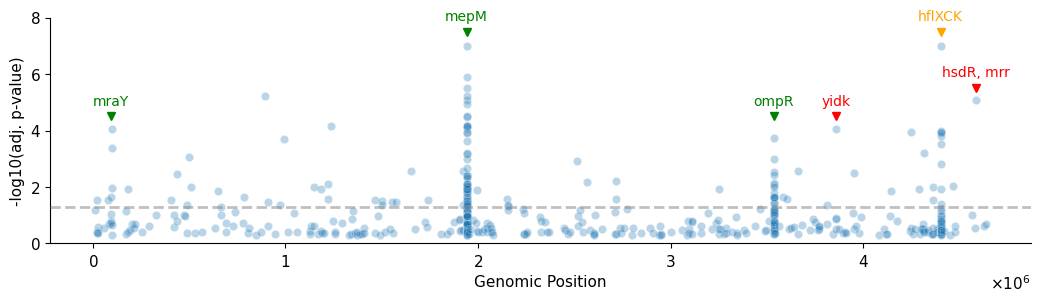

In [11]:
### full genome plot, showing significant mutations in the salt2 experiment

# filtering for plot
pval_cutoff = 0.5
into_plot = combined_salt2_df.copy()
into_plot = into_plot[(into_plot['BH_pval']<pval_cutoff)]


# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="pos",
    y='-log10(BH_pval)',
    kind="scatter",
    height=3,
    aspect=3.5,
    alpha=0.3
)

fontsize = 11
g.set_axis_labels("Genomic Position", "-log10(adj. p-value)", fontsize = fontsize)
g.tight_layout()

for ax in g.axes.flat:
    ax.set_ylim(bottom=0, top=8)
    ax.xaxis.offsetText.set_fontsize(fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.plot(3534500, 4.5, marker='v', color='green', markersize=6, clip_on=False) #ompR
    ax.text(3534500, 4.5 + 0.3, "ompR", color='green', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    ax.plot(1940000, 7.5, marker='v', color='green', markersize=6, clip_on=False) #mepM
    ax.text(1940000, 7.5 + 0.3, "mepM", color='green', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    ax.plot(4400500, 7.5, marker='v', color='orange', markersize=6, clip_on=False) #hfl
    ax.text(4400500, 7.5 + 0.3, "hflXCK", color='orange', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    ax.plot(95900, 4.5, marker='v', color='green', markersize=6, clip_on=False) #mraY
    ax.text(95900, 4.5 + 0.3, "mraY", color='green', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    ax.plot(4586800, 5.5, marker='v', color='red', markersize=6, clip_on=False) #hsdR, mrr
    ax.text(4586800, 5.5 + 0.3, "hsdR, mrr", color='red', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    ax.plot(3860000, 4.5, marker='v', color='red', markersize=6, clip_on=False) #yidk
    ax.text(3860000, 4.5 + 0.3, "yidk", color='red', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    #plot illustrative significance threshold
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=2, alpha=0.5, zorder=10)
    #customize x-axis formatter
    ax.ticklabel_format(axis="x", style="sci", scilimits=(6, 6))
    ax.xaxis.get_major_formatter().set_useMathText(True)


plt.savefig(os.path.join(fig4_out, f"salt_full_genome.png"), dpi=300, bbox_inches='tight')
plt.show()

In [13]:
### how many SNPs detected, total for salt
pval_cutoff = 0.05
into_plot = combined_salt2_df.copy()
#into_plot = into_plot[(into_plot['stouffer_pval']<pval_cutoff)]
into_plot = into_plot[(into_plot['BH_pval']<pval_cutoff)]

into_plot.shape[0]


129

In [14]:
### for text comparison and supplement, how many SNPs detected out at 3 days selection?


#filter for timepoint 3 salt selection
salt3stats = all_mutations_df_annot.copy()
salt3stats = salt3stats[(salt3stats['time_day']==3) & (salt3stats['tx_name']==1234) & (salt3stats['selection_type']=='salt')]


# more precise run, this time just for samples of interest?
salt3stats['permutation_pval_precise'] = compute_empirical_pvals(salt3stats, value_col='all_count', subsample=False)


combined_salt3_df = salt3stats.groupby(['pos', 'ref', 'alt']).progress_apply(stouffer_wrapper, pval_col='permutation_pval_precise').reset_index() #


#BH correction of p-values
combined_salt3_df['BH_pval'] = multipletests(combined_salt3_df['stouffer_pval'], method='fdr_bh')[1]



combined_salt3_df

Using null distribution of size: 75618


100%|██████████| 66909/66909 [00:36<00:00, 1832.61it/s]


,pos,ref,alt,stouffer_pval,count,all_counts,BH_pval
0,174,G,C,0.490710,1,[111],1.0
1,177,T,A,0.585422,1,[74],1.0
2,179,C,G,0.243563,1,[403],1.0
3,191,G,T,0.806438,1,[28],1.0
4,272,G,T,0.582393,1,[75],1.0
...,...,...,...,...,...,...,...
66904,4640694,A,T,0.118714,1,[1158],1.0
66905,4640695,C,A,0.467410,2,"[25, 910]",1.0
66906,4640706,G,A,0.905857,1,[17],1.0
66907,4640912,G,C,0.717703,1,[42],1.0


In [17]:
### how many SNPs detected, total for salt
pval_cutoff = 0.01
into_count = combined_salt3_df.copy()
into_count = into_count[(into_count['stouffer_pval']<pval_cutoff)]

before_BH_correction = into_count.shape[0]
print(f"Number of SNPs before BH correction: {before_BH_correction}")

pval_cutoff = 0.05
into_count = combined_salt3_df.copy()
into_count = into_count[(into_count['BH_pval']<pval_cutoff)]

after_BH_correction = into_count.shape[0]
print(f"Number of SNPs after BH correction: {after_BH_correction}")



Number of SNPs before BH correction: 785
Number of SNPs after BH correction: 42


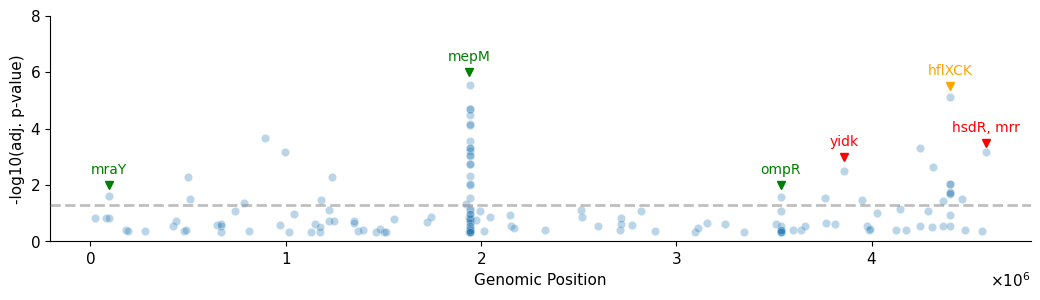

In [152]:
### for supplement, recreate full genome plot for salt3

combined_salt3_df['-log10(BH_pval)'] = -np.log10(combined_salt3_df['BH_pval'])

# filtering for plot
pval_cutoff = 0.5
into_plot = combined_salt3_df.copy()
into_plot = into_plot[(into_plot['BH_pval']<pval_cutoff)]


# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="pos",
    y='-log10(BH_pval)',
    kind="scatter",
    height=3,
    aspect=3.5,
    alpha=0.3
)

fontsize = 11
g.set_axis_labels("Genomic Position", "-log10(adj. p-value)", fontsize = fontsize)
g.tight_layout()

for ax in g.axes.flat:
    ax.set_ylim(bottom=0, top=8)
    ax.xaxis.offsetText.set_fontsize(fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.plot(3534500, 2, marker='v', color='green', markersize=6, clip_on=False) #ompR
    ax.text(3534500, 2 + 0.3, "ompR", color='green', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    ax.plot(1940000, 6, marker='v', color='green', markersize=6, clip_on=False) #mepM
    ax.text(1940000, 6 + 0.3, "mepM", color='green', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    ax.plot(4400500, 5.5, marker='v', color='orange', markersize=6, clip_on=False) #hfl
    ax.text(4400500, 5.5 + 0.3, "hflXCK", color='orange', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    ax.plot(95900, 2, marker='v', color='green', markersize=6, clip_on=False) #mraY
    ax.text(95900, 2 + 0.3, "mraY", color='green', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    ax.plot(4586800, 3.5, marker='v', color='red', markersize=6, clip_on=False) #hsdR, mrr
    ax.text(4586800, 3.5 + 0.3, "hsdR, mrr", color='red', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    ax.plot(3860000, 3, marker='v', color='red', markersize=6, clip_on=False) #yidk
    ax.text(3860000, 3 + 0.3, "yidk", color='red', ha='center', va='bottom',
            fontsize=fontsize-1, clip_on=False)
    #plot illustrative significance threshold
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=2, alpha=0.5, zorder=10)
    #customize x-axis formatter
    ax.ticklabel_format(axis="x", style="sci", scilimits=(6, 6))
    ax.xaxis.get_major_formatter().set_useMathText(True)


plt.savefig(os.path.join(fig4_out, f"supp_salt_full_genome_3days.png"), dpi=300, bbox_inches='tight')
plt.show()

In [147]:
###setup for adding gene cartoons to individual plots


# email to use the Entrez service
Entrez.email = "max@alignbio.org"

# Function to fetch the sequence from NCBI
def fetch_sequence(accession_number):
    handle = Entrez.efetch(db="nucleotide", id=accession_number, rettype="gbwithparts", retmode="text")
    record = SeqIO.read(handle, "genbank")
    handle.close()
    return record

# Function to extract coordinates and sequences for the genes of interest
def extract_gene_info(genome_record, verbose=False):
    gene_info = []
    for feature in genome_record.features:
        if feature.type == "CDS":
            gene_name = feature.qualifiers.get("gene", [""])[0]
            start = int(feature.location.start)  # Convert ExactPosition to int
            end = int(feature.location.end)      # Convert ExactPosition to int
            strand = "+" if feature.location.strand == 1 else "-"
            sequence = feature.extract(genome_record.seq)
            
            if verbose:
                print(f"Gene: {gene_name}, Start: {start}, End: {end}, Strand: {strand}")
            
            gene_info.append({
                "Gene": gene_name,
                "Start": start,
                "End": end,
                "Strand": strand,
                "Sequence": str(sequence)
            })
    
    # Return as a DataFrame for easier manipulation
    return pd.DataFrame(gene_info)

#actually pull mg1655 genome
accession_mg1655 = "U00096.3"
mg1655_record = fetch_sequence(accession_mg1655)

#create gene info dataframe
gene_info_df = extract_gene_info(mg1655_record)


def plot_gene_cartoon(
    gene_name, gene_info_df, padding=500, y_position=0, arrow_color='green', arrow_edge='blue',
    label_offset=0.1, arrow_width=10, arrow_headwidth=20, arrow_headlength=30, gene_name_fontsize=10
):
    """
    Plots a gene cartoon as an arrow, with direction based on the strand (+ or -), and labels the gene.

    Parameters:
    - gene_name: str, name of the gene to plot.
    - gene_info_df: pandas DataFrame, must contain 'Gene', 'Start', 'End', and 'Strand' columns.
    - padding: int, padding around the gene start and end positions.
    - y_position: int or float, y-axis position for the arrow.
    - arrow_color: str, color of the arrow body.
    - arrow_edge: str, color of the arrow edge.
    - label_offset: float, vertical offset for the gene name label.
    """
    # Find the gene in the DataFrame
    gene_row = gene_info_df[gene_info_df['Gene'] == gene_name]
    if gene_row.empty:
        raise ValueError(f"Gene '{gene_name}' not found in the provided DataFrame.")
    
    start = gene_row['Start'].values[0]
    end = gene_row['End'].values[0]
    strand = gene_row['Strand'].values[0]
    
    # Determine the arrow direction
    if strand == "+":
        arrow_start, arrow_end = start, end
    elif strand == "-":
        arrow_start, arrow_end = end, start
    else:
        raise ValueError(f"Invalid strand value '{strand}' for gene '{gene_name}'.")

    # Plot the gene as an arrow
    #plt.xlim(min(start, end) - padding, max(start, end) + padding)  # Set x-axis limits
    plt.annotate(
        '', xy=(arrow_end, y_position), xytext=(arrow_start, y_position),
        arrowprops=dict(facecolor=arrow_color, edgecolor=arrow_edge, width=arrow_width, headwidth=arrow_headwidth, headlength=arrow_headlength)
    )
    
    # Add the gene name label
    plt.text(
        x=(start + end) / 2,  # Midpoint of the arrow
        y=y_position + label_offset,  # Slightly above the arrow
        s=gene_name,  # Label text
        color="black",  # Label color
        fontsize=gene_name_fontsize,  # Font size
        ha="center"  # Center alignment
    )


#gene_info_df

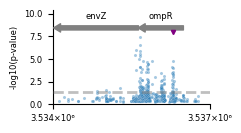

In [119]:
### look at ompR region

#apply more lenient p-value cutoff for looking at single regions
pval_cutoff = 0.5
into_plot = combined_salt2_df.copy()
into_plot = into_plot[(into_plot['stouffer_pval']<pval_cutoff)]

# use filtered data above
xlim_start = 3534500
xlim_end = 3537000
#into_plot = filtered_combined_df.copy()
into_plot = into_plot[into_plot['pos'].isin(range(xlim_start, xlim_end))]

#plt.figure(figsize=(3, 1.5)) # (width, height) in inches

# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="pos",
    y='-log10(pval)',
    kind="scatter",
    height=2,
    aspect=1.1,
    alpha=0.4,
    s = 5
)

#plot constants
top = into_plot['-log10(pval)'].max()
fontsize = 6

gene_examined = "ompR"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top+1,
    arrow_color='gray', arrow_edge='gray', label_offset=1, arrow_width=3, arrow_headwidth=6, arrow_headlength=5, gene_name_fontsize=fontsize)

gene_examined = "envZ"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top+1,
    arrow_color='gray', arrow_edge='gray', label_offset=1, arrow_width=3, arrow_headwidth=6, arrow_headlength=5, gene_name_fontsize=fontsize)


g.set_axis_labels("", "-log10(p-value)", fontsize=fontsize)
g.tight_layout()
for ax in g.axes.flat:
    ax.set_ylim(bottom=0, top=top + 3)
    ax.set_xlim(xlim_start, xlim_end)  #
    ax.tick_params(axis='x', labelsize=fontsize)   # smaller x-ticks
    ax.tick_params(axis='y', labelsize=fontsize)  # keep y-ticks larger
    ax.set_xticks([xlim_start, xlim_end])
    #ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}E6'))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}×10⁶'))
    ### add ompR phosphorylation site
    ax.plot(3536584-55*3, top+0.5, marker='v', color='purple', markersize=3, clip_on=False, zorder=10)
    #plot significance threshold
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=2, alpha=0.5, zorder=10)



#plt.tight_layout()
plt.savefig(os.path.join(fig4_out, f'ompR_region_pval{pval_cutoff}.png'), dpi=600, bbox_inches='tight')
plt.show()

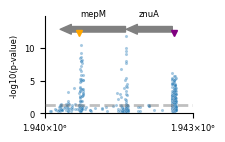

In [120]:
### look at mepM region


#apply more lenient p-value cutoff for looking at single regions
pval_cutoff = 0.5
into_plot = combined_salt2_df.copy()
into_plot = into_plot[(into_plot['stouffer_pval']<pval_cutoff)]


# use filtered data above
xlim_start = 1940000
xlim_end = 1943000
into_plot = into_plot[into_plot['pos'].isin(range(xlim_start, xlim_end))]

# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="pos",
    y='-log10(pval)',
    kind="scatter",
    height=2,
    aspect=1.1,
    alpha=0.4,
    s = 5
)

#plot constants
top = into_plot['-log10(pval)'].max()
fontsize = 6

gene_examined = "mepM"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top + 1,
    arrow_color='gray', arrow_edge='gray', label_offset=2, arrow_width=4, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=fontsize)

gene_examined = "znuA"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top + 1,
    arrow_color='gray', arrow_edge='gray', label_offset=2, arrow_width=4, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=fontsize)

                 
g.set_axis_labels("", "-log10(p-value)", fontsize=fontsize)
g.set_titles(col_template="{col_name}")
g.tight_layout()
for ax in g.axes.flat:
    ax.set_ylim(bottom=0, top=top + 3)
    ax.set_xlim(xlim_start, xlim_end)  #
    ax.tick_params(labelsize=fontsize)
    ax.set_xticks([xlim_start, xlim_end])
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}×10⁶'))
    #add zur box
    ax.plot(1942626, top+0.5, marker='v', color='purple', markersize=4, clip_on=False, zorder=10)
    #add lysM catalytic site
    ax.plot(1941635-313*3, top+0.5, marker='v', color='orange', markersize=4, clip_on=False, zorder=10)
    #plot significance threshold
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=2, alpha=0.5, zorder=10)



plt.savefig(os.path.join(fig4_out, f'mepM_region_pval{pval_cutoff}.png'), dpi=600, bbox_inches='tight')
plt.show()

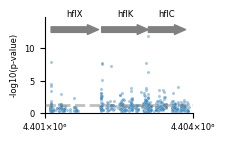

In [121]:
### look at hfl region


#apply more lenient p-value cutoff for looking at single regions
pval_cutoff = 0.5
into_plot = combined_salt2_df.copy()
into_plot = into_plot[(into_plot['stouffer_pval']<pval_cutoff)]



# use filtered data above
xlim_start = 4400500
xlim_end = 4404500
into_plot = into_plot[into_plot['pos'].isin(range(xlim_start, xlim_end))]

# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="pos",
    y='-log10(pval)',
    kind="scatter",
    height=2,
    aspect=1.1,
    alpha=0.4,
    s = 5
)

#plot constants
top = into_plot['-log10(pval)'].max()
fontsize = 6

gene_examined = "hflX"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top + 1,
    arrow_color='gray', arrow_edge='gray', label_offset=2, arrow_width=4, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=fontsize)

gene_examined = "hflK"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top + 1,
    arrow_color='gray', arrow_edge='gray', label_offset=2, arrow_width=4, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=fontsize)

gene_examined = "hflC"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top + 1,
    arrow_color='gray', arrow_edge='gray', label_offset=2, arrow_width=4, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=fontsize)

                 
g.set_axis_labels("", "-log10(p-value)", fontsize=fontsize)
g.set_titles(col_template="{col_name}")
g.tight_layout()
for ax in g.axes.flat:
    ax.set_ylim(bottom=0, top=top + 3)
    ax.set_xlim(xlim_start, xlim_end)  #
    ax.tick_params(labelsize=fontsize)
    ax.set_xticks([xlim_start, xlim_end])
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}×10⁶'))
    #plot significance threshold
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=2, alpha=0.5, zorder=10)



plt.savefig(os.path.join(fig4_out, f'hfl_region_pval{pval_cutoff}.png'), dpi=300, bbox_inches='tight')
plt.show()

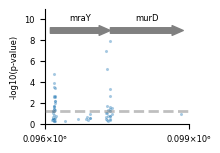

In [123]:
### look at mraY region


#apply more lenient p-value cutoff for looking at single regions
#apply more lenient p-value cutoff for looking at single regions
pval_cutoff = 0.5
into_plot = combined_salt2_df.copy()
into_plot = into_plot[(into_plot['stouffer_pval']<pval_cutoff)]



# use filtered data above
xlim_start = 95900
xlim_end = 98500
into_plot = into_plot[into_plot['pos'].isin(range(xlim_start, xlim_end))]

# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="pos",
    y='-log10(pval)',
    kind="scatter",
    height=2,
    aspect=1.1,
    alpha=0.4,
    s = 5
)

#plot constants
top = into_plot['-log10(pval)'].max()
fontsize = 6

gene_examined = "mraY"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top + 1,
    arrow_color='gray', arrow_edge='gray', label_offset=1, arrow_width=4, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=fontsize)

gene_examined = "murD"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top + 1,
    arrow_color='gray', arrow_edge='gray', label_offset=1, arrow_width=4, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=fontsize)

                 
g.set_axis_labels("", "-log10(p-value)", fontsize=fontsize)
g.set_titles(col_template="{col_name}")
g.tight_layout()
for ax in g.axes.flat:
    ax.set_ylim(bottom=0, top=top + 3)
    ax.set_xlim(xlim_start, xlim_end)  #
    ax.tick_params(labelsize=fontsize)
    ax.set_xticks([xlim_start, xlim_end])
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}×10⁶'))
    #plot significance threshold
    threshold = -np.log10(0.05)
    ax.axhline(y=threshold, color='grey', linestyle='--', linewidth=2, alpha=0.5, zorder=10)


plt.savefig(os.path.join(fig4_out, f'mraY_region_pval{pval_cutoff}.png'), dpi=300, bbox_inches='tight')
plt.show()

/Users/Max_Schubert/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


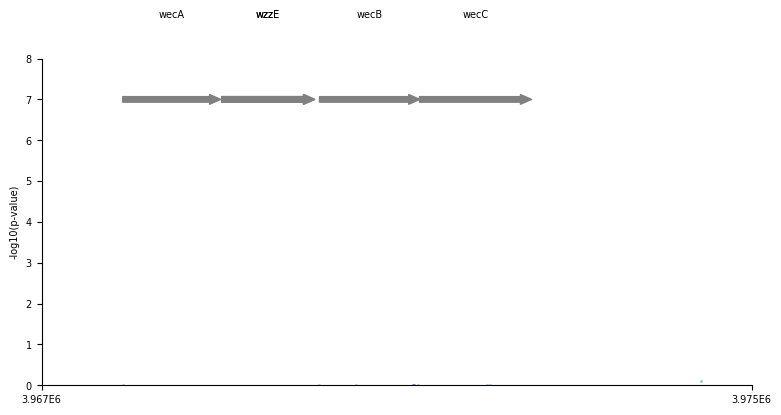

In [ ]:
### explore other regions, here showing the wecA/wzzE/etc region where some ALE mutations are found
### not shown in the publication, but included for completeness


#apply more lenient p-value cutoff for looking at single regions
pval_cutoff = 0.1
into_plot = combined_salt2_df.copy()
into_plot = into_plot[(into_plot['stouffer_pval']<pval_cutoff)& (into_plot['count']>1)]
# use filtered data above
xlim_start = 3967000
xlim_end = 3975000
into_plot = into_plot[into_plot['pos'].isin(range(xlim_start, xlim_end))]

# Generate scatter plot
g = sns.relplot(
    data=into_plot,
    x="pos",
    y='-log10(BH_pval)',
    kind="scatter",
    height=4,
    aspect=2,
    alpha=0.4,
    s = 5
)

top= 8


gene_examined = "wecA"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top-1,
    arrow_color='gray', arrow_edge='gray', label_offset=2, arrow_width=4, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=7)
gene_examined = "wzzE"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top-1,
    arrow_color='gray', arrow_edge='gray', label_offset=2, arrow_width=4, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=7)
gene_examined = "wzzE"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top-1,
    arrow_color='gray', arrow_edge='gray', label_offset=2, arrow_width=4, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=7)    
gene_examined = "wecB"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top-1,
    arrow_color='gray', arrow_edge='gray', label_offset=2, arrow_width=4, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=7)
gene_examined = "wecC"
plot_gene_cartoon(gene_examined, gene_info_df, y_position=top-1,
    arrow_color='gray', arrow_edge='gray', label_offset=2, arrow_width=4, arrow_headwidth=7, arrow_headlength=8, gene_name_fontsize=7)

                 
g.set_axis_labels("", "-log10(p-value)", fontsize=7)
g.set_titles(col_template="{col_name}")
g.tight_layout()
for ax in g.axes.flat:
    ax.set_ylim(bottom=0, top=top)
    ax.set_xlim(xlim_start, xlim_end)  #
    ax.tick_params(labelsize=7)
    ax.set_xticks([xlim_start, xlim_end])
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.3f}E6'))


#plt.savefig(os.path.join(fig3drop, 'mraY_region_pval001.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#interactive plot, to explore other regions more easily
#may be of interest to some readers for further exploration of the data.
import plotly.express as px


# Filter the data
# Apply filters
pval_cutoff = 0.01
into_plot = combined_salt2_df.copy()
into_plot = into_plot[(into_plot['stouffer_pval']<pval_cutoff)] #& (into_plot['count']>1)
into_plot['pos_str'] = into_plot['pos'].astype(str) #string version of pos
# label genes, using fast method
into_plot['Gene'] = into_plot['pos'].apply(fast_annotate)

# Generate interactive scatter plot
fig = px.scatter(
    into_plot,
    x="pos",
    y="-log10(pval)",
    title=f"Stouffer p-value <{pval_cutoff}, 3 replicates",
    labels={"pos_str": "Genomic Position", "stouffer_pval": "Stouffer p-value", "Gene": "Gene"},
    opacity=0.3,
    hover_data=into_plot.columns,  # Optional: show all columns on hover,
    width=1200,   # Width in pixels
    height=600 
)

# Optional: log-scale for p-values
#fig.update_yaxes(type="log")


# Display plot
#fig.write_html("interactive_plot_stouffer.html")
fig.show()